In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
from utils import calc_one_zero_error, calc_f1, calc_precision, calc_recall, calc_density, calc_roc_auc, calc_balanced_accuaray

In [37]:


def plot_fun1(dict_name, metric, alpha, kappa):
    
    # Plot precision list 
    fig, ax = plt.subplots(2,5, figsize = (20,10))
    l = int(len(alpha)/np.prod(ax.shape))
    a = 0
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):

            metric_loss = []
            if metric == "zero-one":
                for k_idx in range(len(kappa)):
                    loss = np.mean([calc_one_zero_error(dict_name['prec_list'][k], dict_name['theta'][a][k_idx][k]) for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
            elif metric == "Frobenius":
                for k_idx in range(len(kappa)):
                    loss = np.mean([scipy.linalg.norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 'fro') for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
            elif metric == "l1":
                for k_idx in range(len(kappa)):
                    loss = np.mean([scipy.linalg.norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 1) for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
           

            ax[i,j].plot(kappa,metric_loss)
            if i ==1:
                ax[i,j].set_xlabel("Kappa")
            if j == 0:
                ax[i,j].set_ylabel("loss")
            ax[i,j].set_ylim((0,2))
            ax[i,j].set_title(f"{metric}, alpha:{np.round(alpha[a],3)}")
            a+=l

    fig.show()



def plot_all_metric_per_alpha(dict_name, kappa_vals, ylim = [0,1], bbox_to_anchor = (1,1)):
    from scipy.linalg import norm

     # Plot precision list 
    fig, ax = plt.subplots(1,len(kappa_vals), figsize = (5*len(kappa_vals),5))
    for i, k_idx in enumerate(kappa_vals):
        metric_zo = []
        metric_l1 = []
        metric_f = []
        for a in range(len(dict_name['alpha'])):
            loss = np.mean([calc_one_zero_error(dict_name['prec_list'][k], dict_name['theta'][a][k_idx][k]) for k in range(len(dict_name['prec_list']))])
            metric_zo.append(loss)

            loss = np.mean([norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 'fro')/norm(dict_name['prec_list'][k], ord = 'fro') for k in range(len(dict_name['prec_list']))])
            metric_f.append(loss)

            loss = np.mean([norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 1)/norm(dict_name['prec_list'][k], ord = 1) for k in range(len(dict_name['prec_list']))])
            metric_l1.append(loss)

        if len(kappa_vals) == 1:
            ax.plot(dict_name['alpha'], metric_zo, label = 'Zero-one')
            ax.plot(dict_name['alpha'], metric_l1, label = 'l1')
            ax.plot(dict_name['alpha'], metric_f, label = 'Frobenius')
            ax.set_title(f"Kappa {np.round(dict_name['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
            ax.set_xlabel("alpha", fontdict = {'fontsize':24})
            ax.set_ylabel("Average loss", fontdict = {'fontsize':24})
            ax.set_ylim(ylim)
            ax.tick_params(axis='both', which='major', labelsize=20)
            legend  = ax.legend(title = "Metric",fontsize = 14, bbox_to_anchor = bbox_to_anchor)
            legend.get_title().set_fontsize('18')



        else:
            ax[i].plot(dict_name['alpha'], metric_zo, label = 'Zero-one')
            ax[i].plot(dict_name['alpha'], metric_l1, label = 'l1')
            ax[i].plot(dict_name['alpha'], metric_f, label = 'Frobenius')
            ax[i].set_title(f"Kappa {np.round(dict_name['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
            ax[i].set_xlabel("alpha", fontdict = {'fontsize':24})
            if i == 0:
                ax[i].set_ylabel("Average loss", fontdict = {'fontsize':24})
            ax[i].set_ylim(ylim)
            if i == len(kappa_vals)-1:
                #ax[i].legend(bbox_to_anchor = (1.4,1))
                legend  = ax[i].legend(title = "Metric",fontsize = 18, bbox_to_anchor = bbox_to_anchor)
                legend.get_title().set_fontsize('18')

            ax[i].tick_params(axis='both', which='major', labelsize=20)


def plot_edges(list_of_dicts, edges, alpha_idx, kappa_idx, bbox_to_anchor = (1,1), y_min = -2, y_max = 2):

    # red grey green blue
    colors_light = ['black', '#D0CDC9', '#6EA96E', '#D6F6F6']
    colors_dark = ['#CC1100', '#8B7500','#00688B', '#00688B']

    fig, ax = plt.subplots(1,len(edges), figsize = (8*len(edges),5))

    plot_once_edge = True
    for cnt1, dict_name in enumerate(list_of_dicts):

        d = dict_name['theta'][0][0].shape[1]


        
        for cnt2, e in enumerate(edges):

            if len(edges) == 1:
                if plot_once_edge:
                    ax.plot(dict_name['prec_list'][:,e[0],e[1]], label = "True", color = colors_light[0])
                
                ax.set_title(f"Edge ({e[0]+1}, {e[1]+1}), alpha= {np.round(dict_name['alpha'][alpha_idx],2)}, kappa =  {np.round(dict_name['kappa'][kappa_idx],2)}", fontdict = {'fontsize':24})
                    
                ax.plot(dict_name['theta'][alpha_idx][kappa_idx][:,e[0],e[1]], label = f"Estimate, n={dict_name['nr_obs_per_graph']}", linestyle = '--', color = colors_dark[cnt1])
                
                legend = ax.legend(bbox_to_anchor = bbox_to_anchor)
                legend.get_title().set_fontsize('24')
                ax.set_xlabel("Time", fontdict = {'fontsize':24})
                ax.set_ylabel("Edge weight", fontdict = {'fontsize':24})
                ax.tick_params(axis='both', which='major', labelsize=20)

            else:
                if plot_once_edge:
                    ax[cnt2].plot(dict_name['prec_list'][:,e[0],e[1]], label = "True", color = colors_light[0])
                
                ax[cnt2].set_title(f"e=({e[0]+1}, {e[1]+1})", fontdict = {'fontsize':24})

                ax[cnt2].plot(dict_name['theta'][alpha_idx][kappa_idx][:,e[0],e[1]], label = f"Estimate, n={dict_name['nr_obs_per_graph']}", linestyle = '--', color = colors_dark[cnt1])
                 
                if cnt2 == len(edges)-1:
                    legend = ax[cnt2].legend(bbox_to_anchor = (1,1),fontsize = 20)
                    legend.get_title().set_fontsize('18')
                ax[cnt2].set_xlabel("Time", fontdict = {'fontsize':24})
                ax[0].set_ylabel(f"Edge weight", fontdict = {'fontsize':24})
                ax[cnt2].tick_params(axis='both', which='major', labelsize=20)
                #ax[cnt2].set_ylim([y_min, y_max ])

        plot_once_edge = False


def find_min(change_point_dict):
    from scipy.linalg import norm
    # Find which gives minimum
    current_min_zo = np.inf
    edge_min_zo = [0,0]

    current_min_l1 = np.inf
    edge_min_l1 = [0,0]

    current_min_f = np.inf
    edge_min_f = [0,0]


    for i in range(len(change_point_dict['alpha'])):
        for j in range(len(change_point_dict['kappa'])):
            
            loss = np.mean([calc_one_zero_error(change_point_dict['prec_list'][k], change_point_dict['theta'][i][j][k]) for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_zo:
                current_min_zo = loss

                edge_min_zo[0] = i
                edge_min_zo[1] = j

            loss = np.mean([norm(change_point_dict['prec_list'][k]- change_point_dict['theta'][i][j][k],ord = 'fro')/norm(change_point_dict['prec_list'][k], ord = 'fro') for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_f:
                current_min_f = loss

                edge_min_f[0] = i
                edge_min_f[1] = j

            loss = np.mean([norm(change_point_dict['prec_list'][k]- change_point_dict['theta'][i][j][k],ord = 1)/norm(change_point_dict['prec_list'][k], ord = 'fro') for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_l1:
                current_min_l1 = loss

                edge_min_l1[0] = i
                edge_min_l1[1] = j



    print(f"zo {edge_min_zo} {current_min_zo}")
    print(f"l1 {edge_min_l1}  {current_min_l1}")
    print(f"F {edge_min_f}  {current_min_f}")


In [3]:
from sklearn.datasets import make_sparse_spd_matrix
prec_0 = make_sparse_spd_matrix(5, alpha=0.3, smallest_coef=-0.2, largest_coef=0.8, norm_diag = True,random_state=42)
prec_0

array([[ 1.        ,  0.        ,  0.13373616,  0.        , -0.54739138],
       [ 0.        ,  1.        ,  0.        ,  0.09171019, -0.31028148],
       [ 0.13373616,  0.        ,  1.        ,  0.        , -0.5042745 ],
       [ 0.        ,  0.09171019,  0.        ,  1.        ,  0.        ],
       [-0.54739138, -0.31028148, -0.5042745 ,  0.        ,  1.        ]])

# Read

In [81]:
# Read
import pickle
te = 'perturbed-node'
# with open(f'../data/joint/joint_change_gaussian3_{te}_200_10.pkl', 'rb') as handle:
#     change_point_dict1 = pickle.load(handle)
# with open(f'../data/joint/joint_change_gaussian2_{te}_1000_50.pkl', 'rb') as handle:
#     change_point_dict2 = pickle.load(handle)
with open(f'../data/joint/joint_change_gaussian3_{te}_900_100.pkl', 'rb') as handle:
    change_point_dict3 = pickle.load(handle)

In [82]:
find_min(change_point_dict3)

zo [10, 16] 0.2
l1 [0, 6]  0.16453506991226216
F [0, 10]  0.1419697694451475


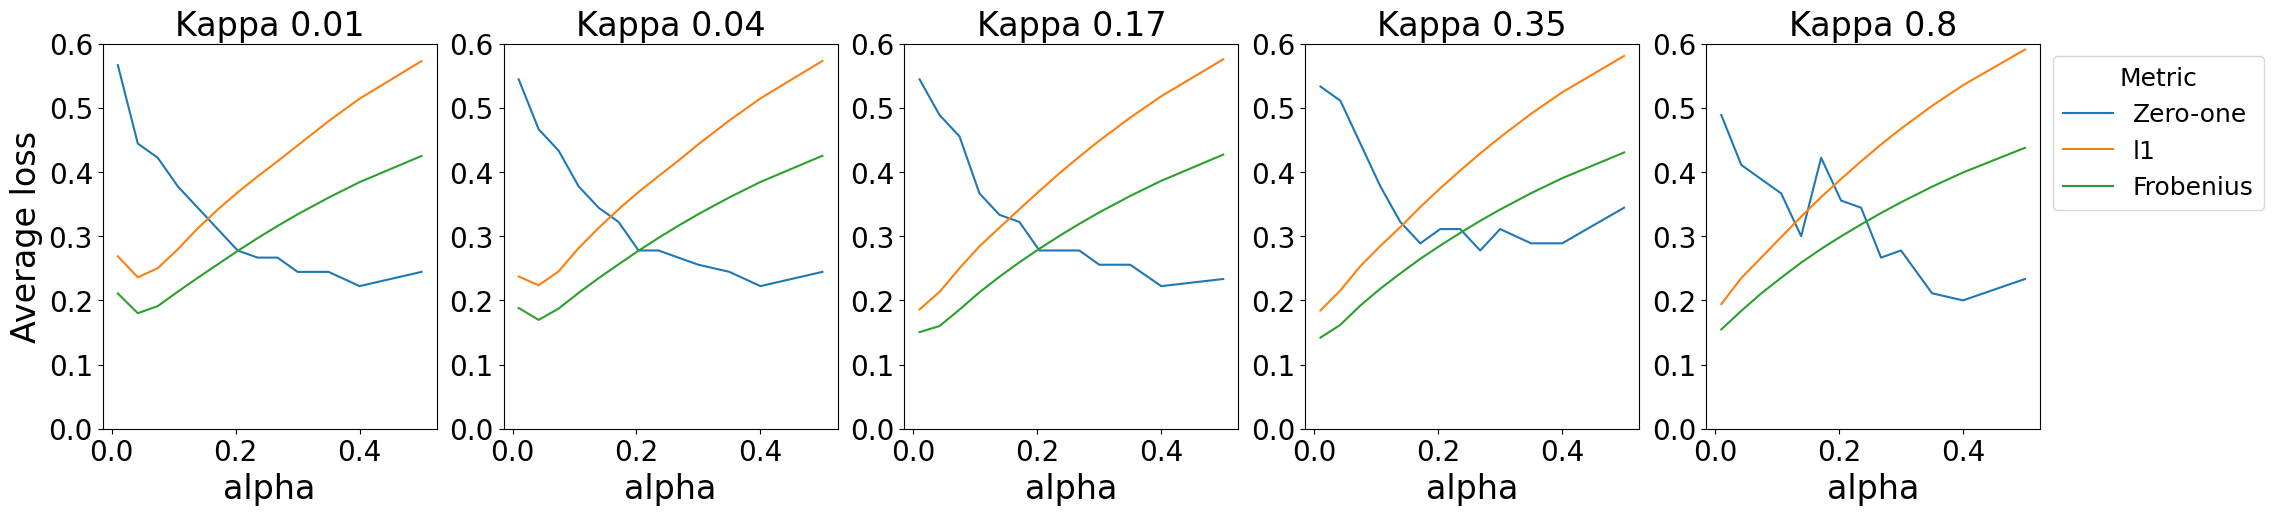

In [83]:
plot_all_metric_per_alpha(change_point_dict3, [0,1,5,10,15], ylim=[0,0.6])

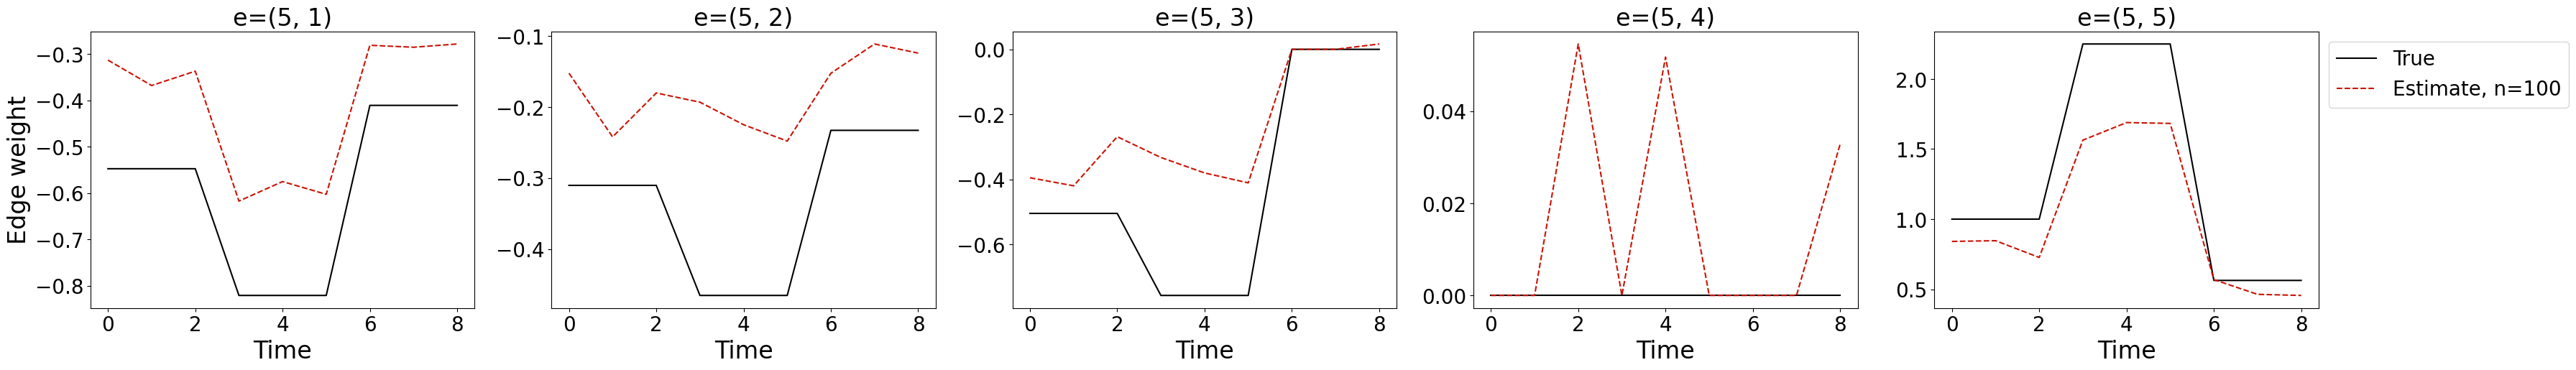

In [84]:
plot_edges([change_point_dict3], [(4,0), (4,1), (4,2), (4,3), (4,4)], 4, 4)

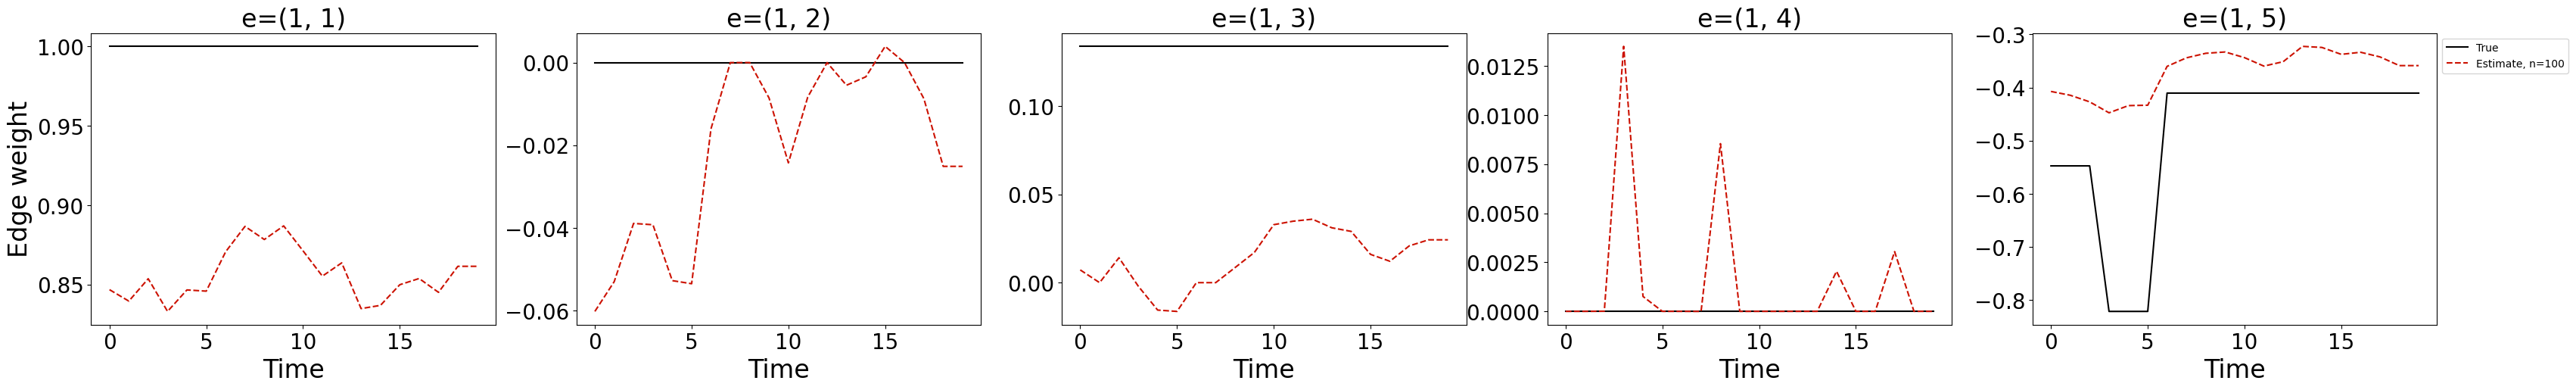

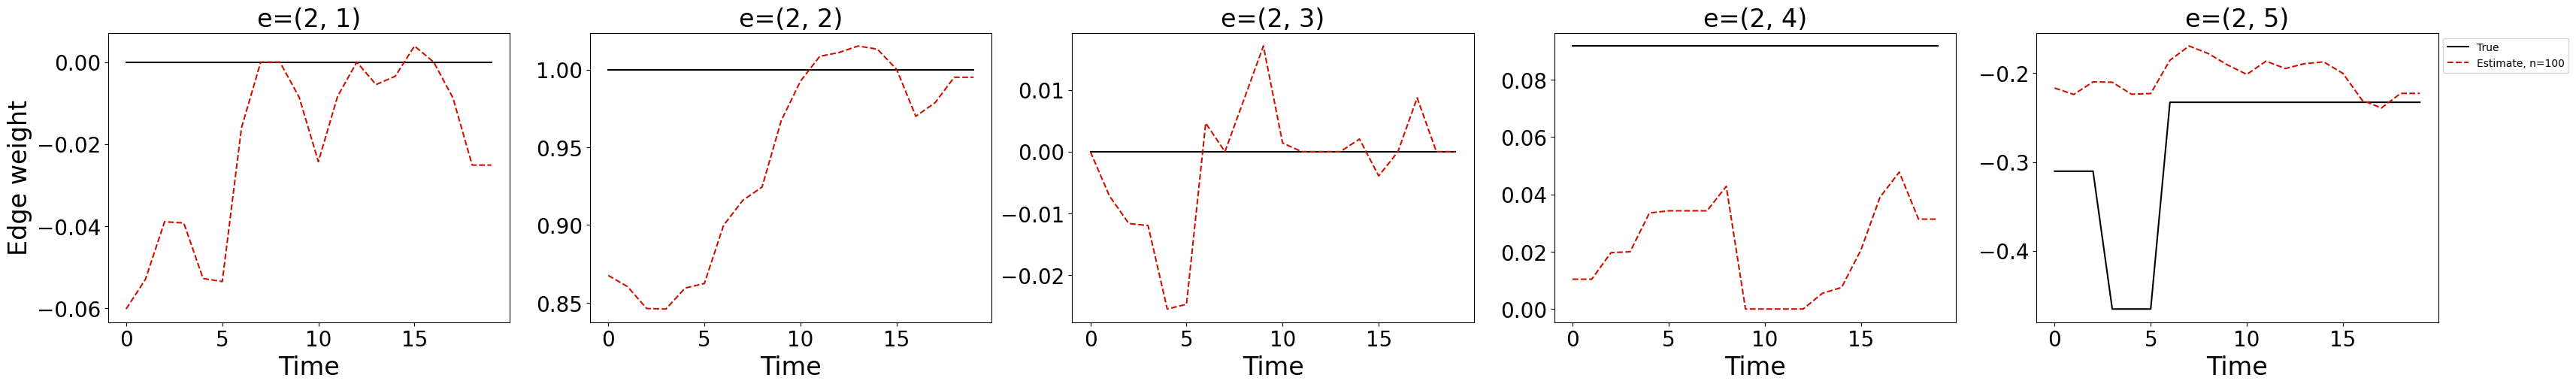

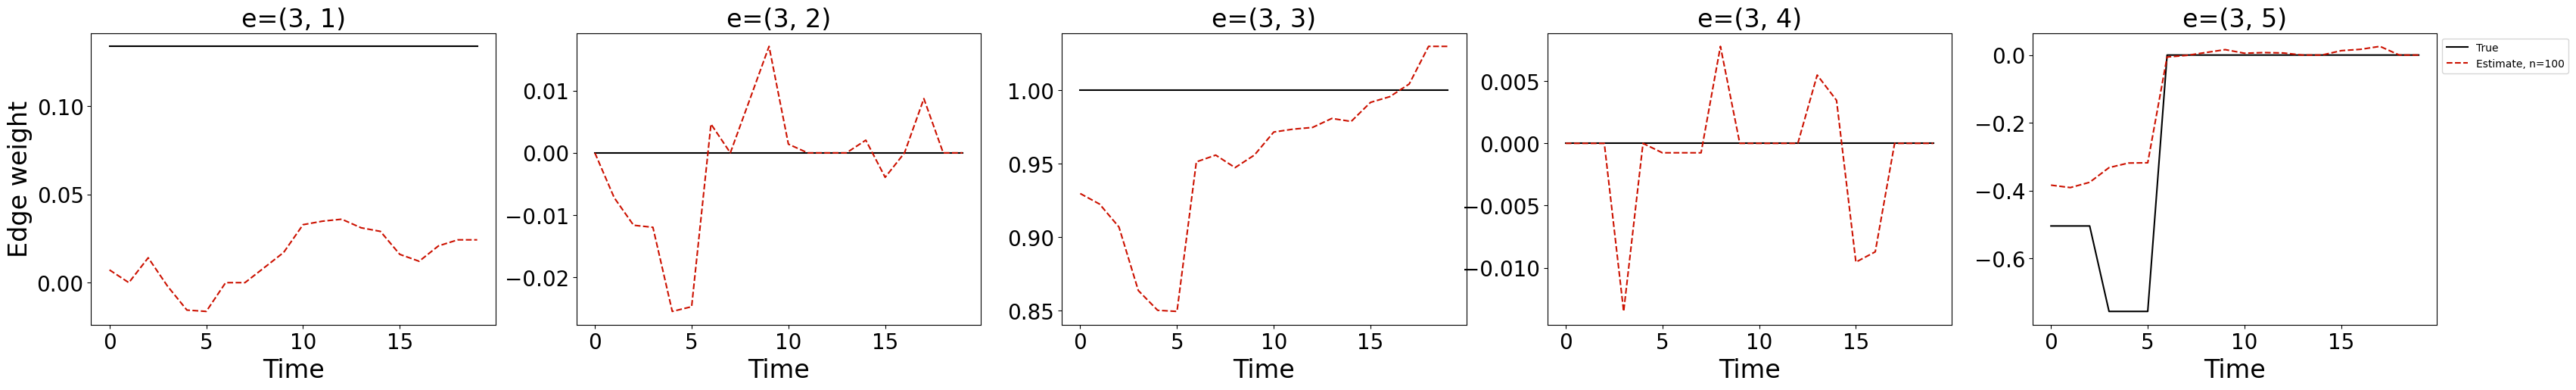

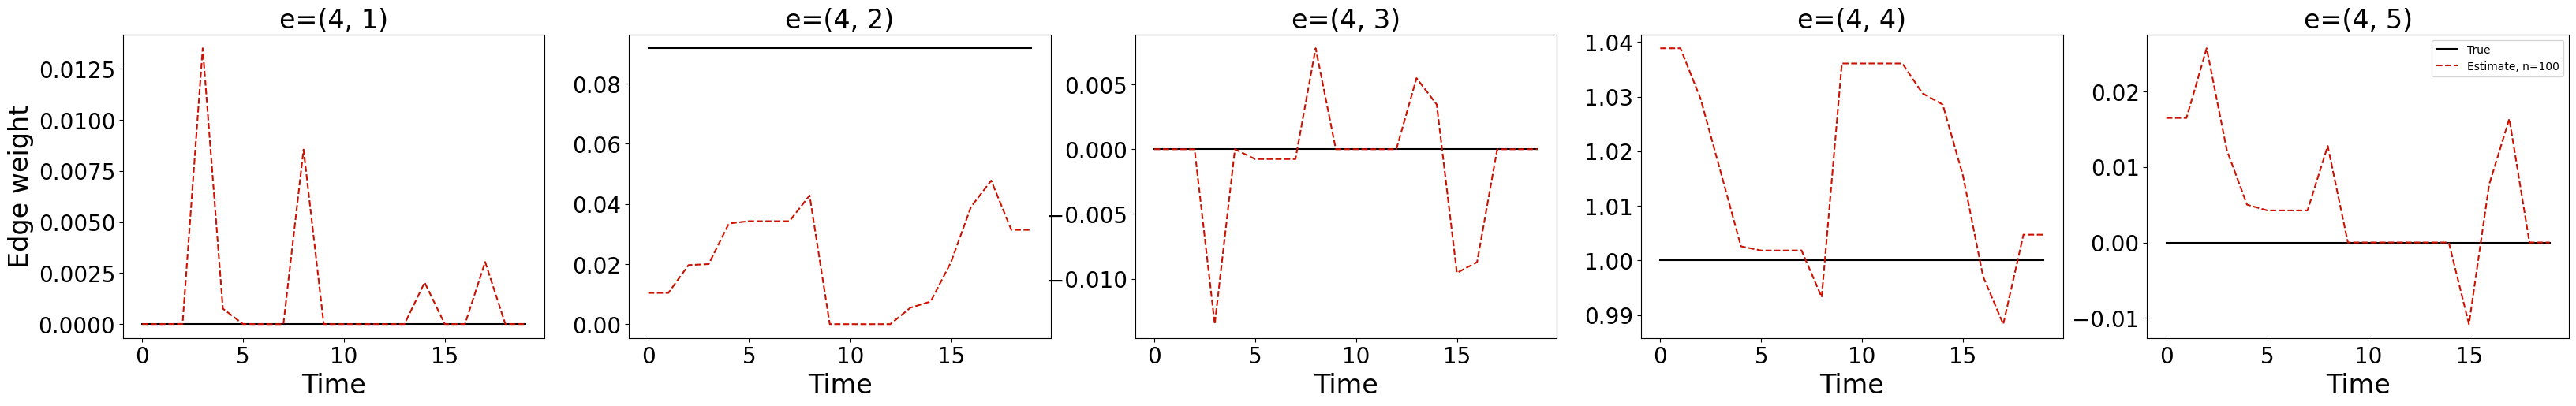

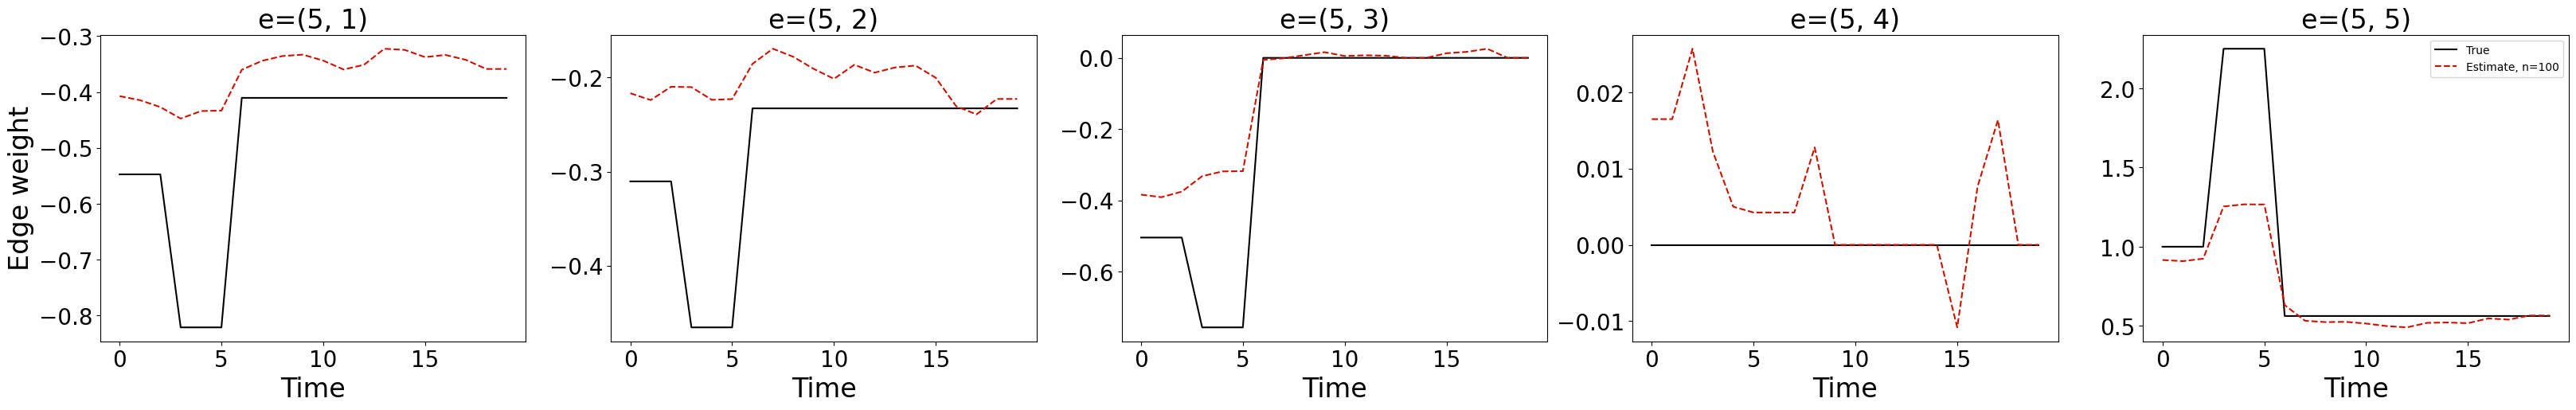

In [30]:
for i in range(5):
    plot_edges([change_point_dict3], [(i,0), (i,1), (i,2), (i,3), (i,4)], 4, 8)

# TEST

precision matrix 0

In [4]:

prec_0 = make_sparse_spd_matrix(5, alpha=0.3, smallest_coef=-0.2, largest_coef=0.8, norm_diag = True,random_state=42)
print("precision")
print(prec_0)
print("Covariance")
S = np.linalg.inv(prec_0)
print(S)

precision
[[ 1.          0.          0.13373616  0.         -0.54739138]
 [ 0.          1.          0.          0.09171019 -0.31028148]
 [ 0.13373616  0.          1.          0.         -0.5042745 ]
 [ 0.          0.09171019  0.          1.          0.        ]
 [-0.54739138 -0.31028148 -0.5042745   0.          1.        ]]
Covariance
[[ 1.59497689  0.36930761  0.38185046 -0.03386927  1.18022337]
 [ 0.36930761  1.24495262  0.33169356 -0.11417484  0.75570615]
 [ 0.38185046  0.33169356  1.48347252 -0.03041968  1.06001739]
 [-0.03386927 -0.11417484 -0.03041968  1.010471   -0.06930595]
 [ 1.18022337  0.75570615  1.06001739 -0.06930595  2.41506546]]


Generate time series of precision matrices

In [32]:
rnd_state = np.random.RandomState(42)
rnd_state2 = np.random.RandomState(1)


nr_obs_per_graph = 50
n = 20*nr_obs_per_graph
d = prec_0.shape[0]
# Simulate 
Xs = np.zeros((n,d))
prec_list = [prec_0]
is_psd = False
cnt = 0
while cnt*nr_obs_per_graph <n:
    if cnt > 0:
        prec_tmp = prec_list[cnt-1].copy()
        # element to change
        i = 0#np.random.randint(0,d)

        
        if rnd_state.uniform() < 0.6:
            
            if rnd_state.uniform() < 0.85:
                for j in range(1,d):
                    w = prec_tmp[0,0]*(rnd_state.uniform(0.2, 0.5))
                    prec_tmp[i,j] = w
                    prec_tmp[j,i] = w
            else:
                for j in range(1,d):
                    prec_tmp[i,j] = 0
                    prec_tmp[j,i] = 0
        else:
            for j in range(1,d):
                w = prec_tmp[0,0]*(rnd_state.uniform(0.6, 0.8))
                prec_tmp[i,j] = w
                prec_tmp[j,i] = w
        
        u,v = np.linalg.eigh(prec_tmp)
        if np.any(u<0.0):
            continue
        prec_list.append(prec_tmp)

    Xs[cnt*nr_obs_per_graph:(cnt+1)*nr_obs_per_graph ] = rnd_state2.multivariate_normal(mean = np.zeros(d), cov = np.linalg.inv(prec_list[cnt]),size=(nr_obs_per_graph) )

    cnt +=1




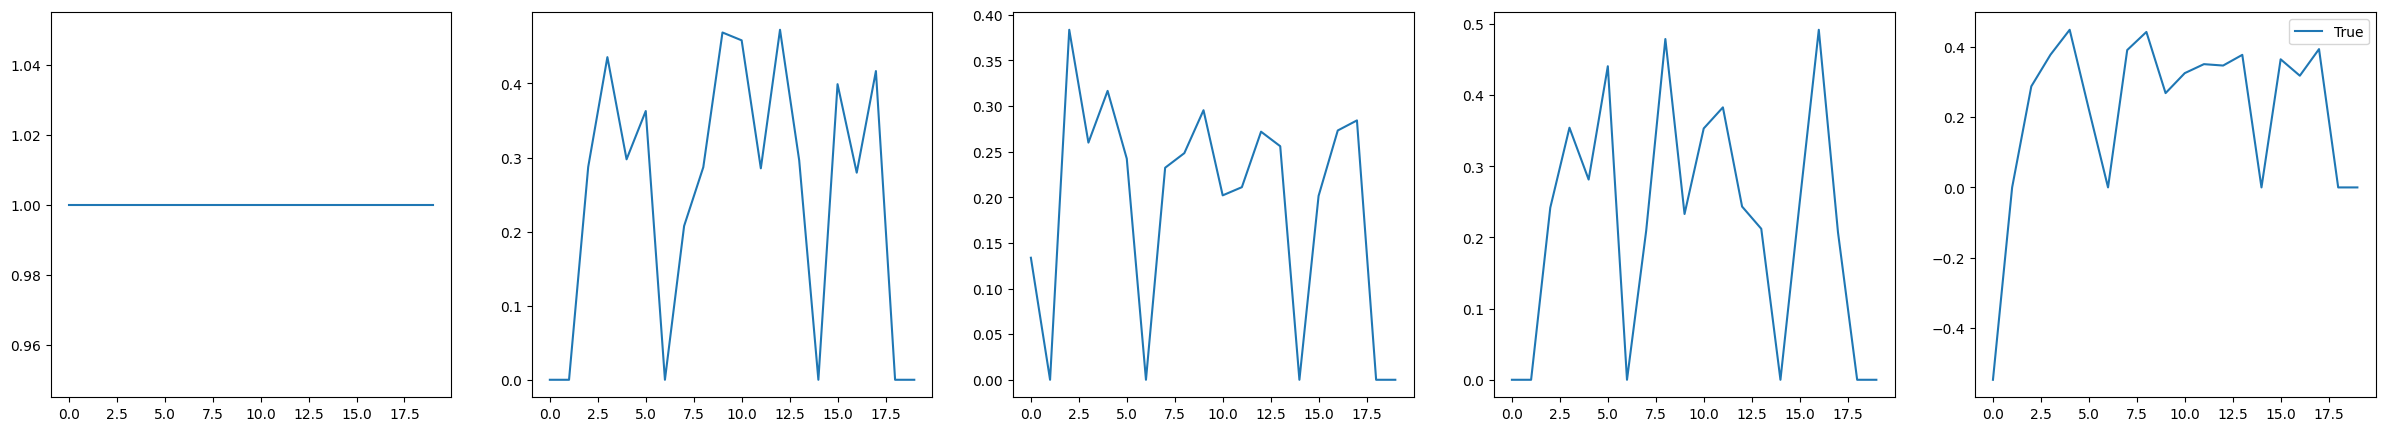

In [33]:
prec_list = np.array(prec_list)
fig, ax = plt.subplots(1,5, figsize = (30,5))

for i in range(d):
    ax[i].plot(prec_list[:,0,i], label = "True")
    if i == d-1:
        ax[i].legend(bbox_to_anchor = (1,1))